In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
def get_test_decending_then_ascending_mkt_data(dim: int = 100, step: int = 100) -> pd.DataFrame:
        # Generate pandas dataframe of timestamps records
        df = pd.DataFrame(
            data={
                "timestamp": pd.date_range(
                    start=datetime.now(), periods=dim, freq=timedelta(hours=1)
                ),
                "inx": np.arange(dim),
            }
        )
        # mid point of the data
        mid = int(dim / 2)
        # Create nunmpy array of dim in length
        arr = np.arange(dim)
        for i in range(mid):
            arr[i] = (mid - i) * step + 1000
        for i in range(mid, dim):
            arr[i] = (i - mid) * step + 1000
        df.set_index("timestamp", inplace=True, drop=True)
        # Assign numpy array arr to df["close"]
        df["close"] = arr
        df["price_movement"] = df["close"].diff()
        return df

In [3]:
test_data = get_test_decending_then_ascending_mkt_data(100)
LOOK_BACK = 3

In [4]:
from preprocess_data.domains.features_gen import calculate_rsi
rsi = calculate_rsi(df_price=test_data["close"],window=14)

In [5]:
rsi

timestamp
2023-05-02 09:21:18.955804          NaN
2023-05-02 10:21:18.955804          NaN
2023-05-02 11:21:18.955804          NaN
2023-05-02 12:21:18.955804          NaN
2023-05-02 13:21:18.955804          NaN
                                ...    
2023-05-06 08:21:18.955804    96.522583
2023-05-06 09:21:18.955804    96.771172
2023-05-06 10:21:18.955804    97.001977
2023-05-06 11:21:18.955804    97.216271
2023-05-06 12:21:18.955804    97.415239
Name: close, Length: 100, dtype: float64

In [6]:
# df_price = test_data["close"]
# periods=14
# delta = df_price.diff()
# up = delta.clip(lower=0)
# down = -1*delta.clip(upper=0)
# ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
# ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
# rsi = ma_up / ma_down
# rsi = 100 - (100/(1 + rsi))

In [7]:
import talib
rsi_talib = talib.RSI(test_data["close"], timeperiod=14)

In [8]:
len(rsi_talib)

100

In [9]:
len(rsi_talib.dropna())

86

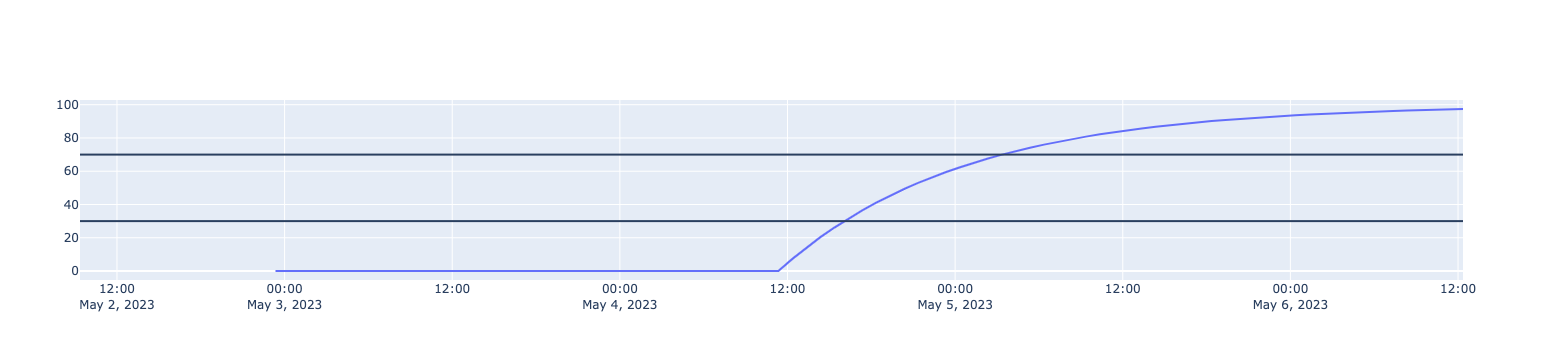

In [10]:
# Use Plotly Express to plot the RSI
# then add a horizontal line at 70 and 30
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=rsi.index, y=rsi.values, name="rsi", mode="lines"))

fig.add_hline(y=70)
fig.add_hline(y=30)
fig.show()

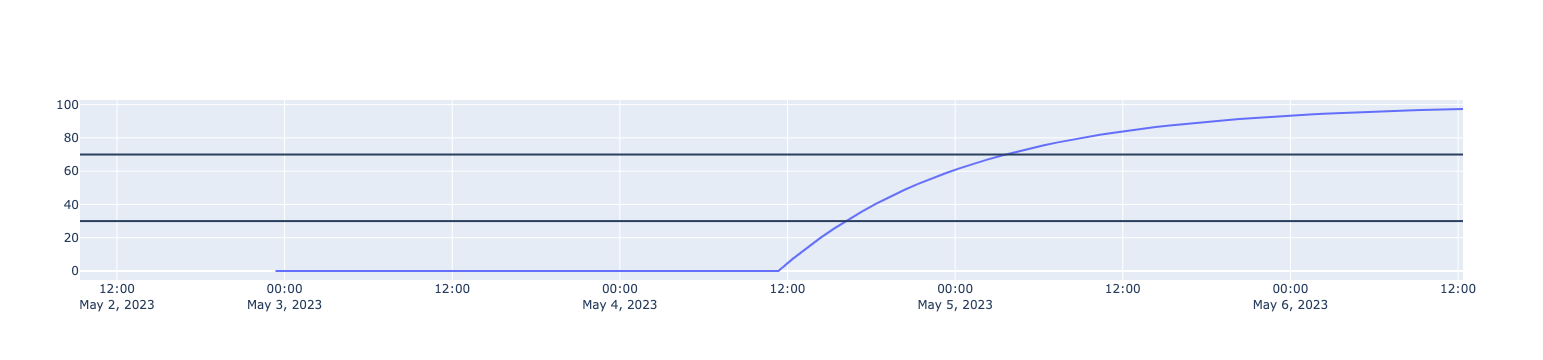

In [11]:
# Use Plotly Express to plot the RSI
# then add a horizontal line at 70 and 30
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=rsi_talib.index, y=rsi_talib.values, name="rsi", mode="lines"))

fig.add_hline(y=70)
fig.add_hline(y=30)
fig.show()

##  Load historical data

In [12]:
from cryptomarketdata.port.db_client import   get_data_db_client, Database_Type
from cryptomarketdata.utility import resample_timeframe
from preprocess_data.domains.features_gen import RSI_Feature
from datetime import datetime, timedelta

/var/conda/miniconda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning:

urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!



In [13]:
local_data_dir = "data"
test_exchange = "kraken"
test_symbol = "ETHUSD"
from_time_ms:int = int(datetime(2022,1,1).timestamp()*1000)
to_time_ms:int = int(datetime(2023,3,1).timestamp()*1000)
LOOK_BACK:int = 3
rsi_window = 14

In [14]:
db_client = get_data_db_client(
        exchange=test_exchange, database_type=Database_Type.PARQUET, data_directory=local_data_dir
    )

2023-05-02 09:21:20,101 [INFO] Data stored in data (db_client.py:35)
2023-05-02 09:21:20,115 [INFO] Use Parquet data set (db_client.py:41)
2023-05-02 09:21:20,121 [INFO] Using local file system (parquet_database.py:55)
2023-05-02 09:21:20,121 [INFO] Using local file system (parquet_database.py:55)


In [15]:
candles = db_client.get_candles(
    symbol=test_symbol, from_time=from_time_ms, to_time=to_time_ms
)
candles_15Min = resample_timeframe(data=candles, tf="15Min")

rsi = calculate_rsi(df_price=candles_15Min["close"],window=rsi_window)

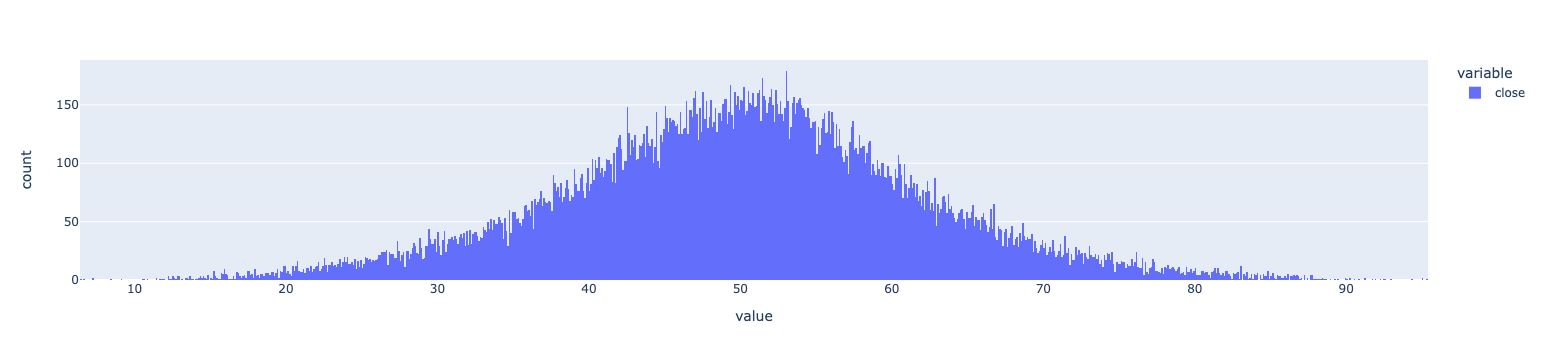

In [16]:
# Use plotly to plot histogram of rsi with 1000 bins
import plotly.express as px
fig = px.histogram(rsi, nbins=1000)
fig.show()

In [17]:
rsi_feature = RSI_Feature(
        df_price=candles_15Min["close"], dimension=LOOK_BACK, rsi_window=rsi_window
    )

In [18]:
rsi_feature_array = rsi_feature.output_feature_array(normalize=True)

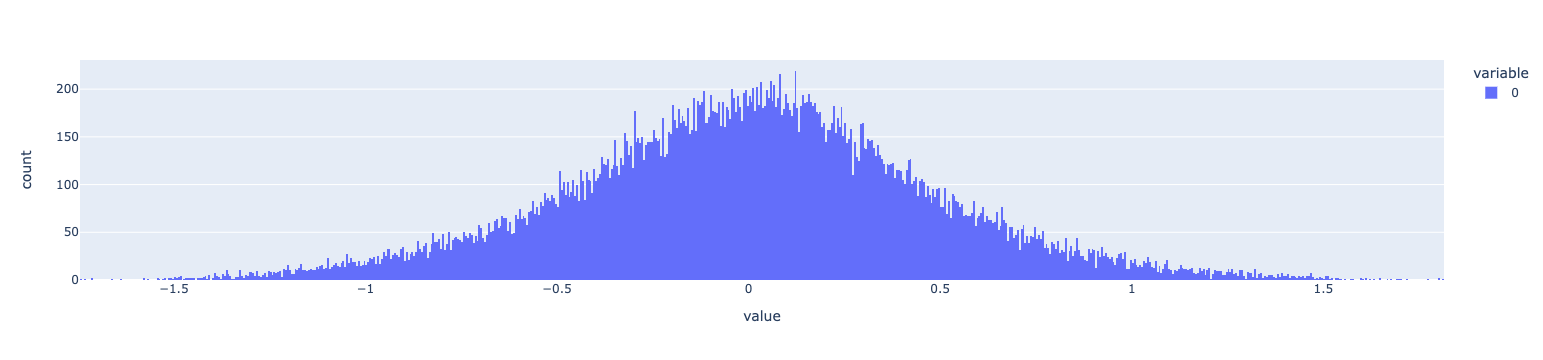

In [19]:
# Use plotly to plot histogram of rsi_feature_array[:,0] with 1000 bins
import plotly.express as px
fig = px.histogram(rsi_feature_array[:,0], nbins=1000)
fig.show()

In [22]:
rsi_feature_array

array([[-0.08334109,  0.41740333,  0.8315853 ],
       [ 0.07184119, -0.08334109,  0.41740333],
       [-0.02173448,  0.07184119, -0.08334109],
       ...,
       [-0.67871199, -0.69364322, -0.63567949],
       [-0.77584276, -0.67871199, -0.69364322],
       [-0.63585543, -0.77584276, -0.67871199]])